 # Lamieux Method For Brain Image Segmentation
 
Replication of the results reported by Lamieux et al. : Fast, accurate, and reproducible automatic segmentation of the brain in T1-weighted volume MRI data.

 ### Initial Setup

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from ipywidgets import interact, FloatSlider

import SimpleITK as sitk
import numpy as np

from myshow import myshow, myshow3d
%env SITK_SHOW_COMMAND /Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP 

env: SITK_SHOW_COMMAND=/Applications/ITK-SNAP.app/Contents/MacOS/ITK-SNAP


 Loading data and initial visualization...

In [2]:
img_T1 = sitk.ReadImage("../data/IXI002-Guys-0828-MPRAGESEN_-s256_-0301-00003-000001-01.nii")

# To visualize the labels image in RGB with needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)

myshow3d(img_T1)
sitk.Show(img_T1)

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

 ## Function definitions....

In [3]:
def slicesInRange(img, t, center=64, zoffset=10, nimages=3, dps=80):
    start = center - zoffset * nimages // 2
    end = center + zoffset * nimages // 3
    return myshow3d(img, zslices=range(start, end+1, zoffset), dpi=80, title=t)

def OstsuThresh(img):
    otsuFilter = sitk.OtsuThresholdImageFilter()
    otsuFilter.SetOutsideValue(255)
    otsuFilter.SetInsideValue(0)
    mask = otsuFilter.Execute(img)
    return mask, otsuFilter.GetThreshold()

def Threshold(img, threshValue):
    thresh = sitk.BinaryThresholdImageFilter()
    # defines threshold window
    thresh.SetUpperThreshold(threshValue)
    thresh.SetLowerThreshold(0)
    # defines inner and outer values
    thresh.SetOutsideValue(255)
    thresh.SetInsideValue(0)
    # apply threshold
    return thresh.Execute(img)

''' Performs step 2 : Initial Brain Disconnection'''
def InitialBrainDisconnection(img, threshOtsuValue, threshMult):
    # Compute a mask based on ostu value
    threshValue = threshMult * threshOtsuValue / 3
    mask = Threshold(img, threshValue)
    # Apply Conditionnal Morphological Opening Operation
    mask = MorphOpening(mask, kernelSize=3, kernelType=1)
    # Connectivity Components Analysis
    filter = sitk.ConnectedComponentImageFilter()
    components = filter.Execute(img, mask, True)
    # reorder componends
    filter = sitk.RelabelComponentImageFilter()
    reorderedComponents = filter.Execute(components)
    # get largest component size
    component_size = filter.GetSizeOfObjectsInPixels()[0]
    # get image largest component label (pixel value = 1)
    dst = sitk.BinaryThreshold(reorderedComponents, 1, 1)
    
    # debug...
    slicesInRange(sitk.LabelOverlay(img_T1_255, dst), 'ThreshMult: ' + str(threshMult))
    
    return dst, component_size

''' Apply a morphological opening operation '''
def MorphOpening(seg, kernelSize, kernelType):
    filter = sitk.BinaryMorphologicalOpeningImageFilter()
    filter.SetKernelType(kernelType)
    filter.SetKernelRadius(kernelSize)
    dst = filter.Execute(seg)
    return dst

''' Apply a morphological open operation to seg when img pixels are over threshValue '''
def ConditionnalOpening(img, seg, threshValue, kernelSize, kernelType):
    mask = Threshold(img, threshValue)
    maskedSeg = sitk.Mask(seg, mask)
    filter = sitk.BinaryMorphologicalOpeningImageFilter()
    filter.SetKernelType(kernelType)
    filter.SetKernelRadius(kernelSize)
    dst = filter.Execute(maskedSeg)
    return dst

''' Apply a morphological dilate operation to seg when img pixels are over threshValue '''
def ConditionnalDilate(img, seg, threshValue, kernelSize, kernelType):
    mask = Threshold(img, threshValue)
    maskedSeg = sitk.Mask(seg, mask)
    filter = sitk.GrayscaleGeodesicDilateImageFilter()
    filter.SetKernelType(kernelType)
    filter.SetKernelRadius(kernelSize)
    dst = filter.Execute(img, maskedSeg, runOneIteration=True, fullyConnected=True)
    return dst

''' Returns true for a vector composed only by zeros and false otherwise. '''
def isAllZero(vec):
    return not np.any(vec)

''' Returns true if vector contains any zero value, false otherwise. '''
def hasAnyZero(vec):
    if np.size(np.nonzero(vec)) == np.size(vec):
        return False
    else:
        return True


### Step 0: Non-Uniformity Correction

In [6]:
img_double = sitk.Cast(img_T1, sitk.sitkFloat32)
uniform_img = sitk.N4BiasFieldCorrection(img_double);
sitk.Show(uniform_img)

In [10]:
img_T1 = sitk.Cast(uniform_img, sitk.sitkUInt16)

 ### Step 1: Calculating the Foreground Threshold Level

In [11]:
mask, threshOtsuValue = OstsuThresh(img_T1)
I_scf = threshOtsuValue / 3.5 + 6
# To visualize the labels image in RGB with needs a image with 0-255 range
myshow(sitk.LabelOverlay(img_T1_255, mask), "Otsu Thresholding")
print('Threshold Otshu value: ', threshOtsuValue)
print('Estimated cerebrospinal fluid (CSF) intensity : ', I_scf)

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

Threshold Otshu value:  181.0
Estimated cerebrospinal fluid (CSF) intensity :  57.714285714285715


 ## Step 2 : Initial Brain Disconnection
 Performs a loop where each connected component volume found on the image is calculated. The loop stops when the change observed in the volume is greater then 3 times the moving average of the last interactions.

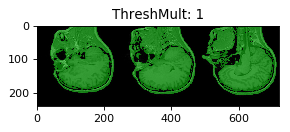

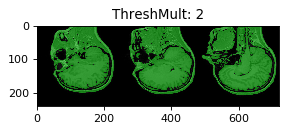

0.0818227082911109


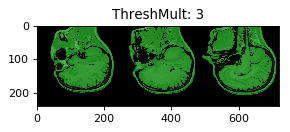

0.08789448370016922


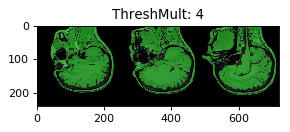

0.11832762507837881


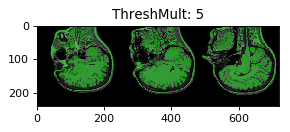

0.24120625790232775
Number of interactions:  5


interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [12]:
# initialize variables
threshMult = 1
largestComponentSize = 0
# first call of the interactive function
largestComponentImg, initialComponentSize = InitialBrainDisconnection(img_T1, threshOtsuValue, threshMult)
# initialize loop variables
largestComponentSize = initialComponentSize
AverageWindowSize = 3 # equals to moving average window size
MAX_INTERACTIONS = 10 # max interactions of the loop
relativeDecreace = 0 # actual relative decreace
relativeDecreacesVec = np.zeros(AverageWindowSize) # vector of past relative decreases

''' Loops InitialBrainDisconnection ultil the reduction of brain volume is greater than the moving average of the last 3 interactions. 
If relativeDecreacesVec contains only zeroes, continue. 
'''
while(relativeDecreace <= (np.mean(relativeDecreacesVec)) 
      or hasAnyZero(relativeDecreacesVec)):
    # updates loop break condition variables ------------------------------------------------------------
    movingAvgIdx = threshMult % AverageWindowSize  # modulo is the index of the vector
    relativeDecreacesVec[movingAvgIdx] = relativeDecreace # add last decrease to past decreases vector
    lastComponetSize = largestComponentSize # updates last component size
    threshMult = threshMult + 1 # updates thresh multiplier
    ''' If maximum interactions its overcome, exit loop '''
    if threshMult >= MAX_INTERACTIONS:
        break
    # calls initial brain disconnection
    largestComponentImg, largestComponentSize = InitialBrainDisconnection(img_T1, threshOtsuValue, threshMult)
    # compute relative decrease
    relativeDecreace = np.abs(largestComponentSize - lastComponetSize)/ lastComponetSize
    print(relativeDecreace)

print('Number of interactions: ', threshMult)
myshow(sitk.LabelOverlay(img_T1_255, largestComponentImg), "Largest Component Label")

In [13]:
print(relativeDecreace)
print(relativeDecreacesVec)

0.24120625790232775
[0.08789448 0.11832763 0.08182271]


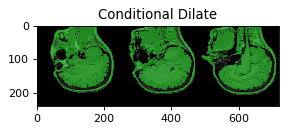

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [32]:
# Apply Conditionnal Morphological Dilate (reccomended : 3mm)
dilated_largest_component = ConditionnalDilate(img_T1, largestComponentImg, threshOtsuValue, kernelSize=1, kernelType=1)
slicesInRange(sitk.LabelOverlay(img_T1_255, dilated_largest_component), "Conditional Dilate")
myshow(sitk.LabelOverlay(img_T1_255, dilated_largest_component), "Conditional Dilate")

### Step 3: Initial Mara Dura Removal

In [33]:
# call a multiple otsu threshold to separate WM, GM et SCF
maskedImg = sitk.Mask(img_T1, dilated_largest_component)
# call filter
filter = sitk.OtsuMultipleThresholdsImageFilter()
filter.SetNumberOfThresholds(3)
labelOtsu =filter.Execute(maskedImg)
multipleOtsu = filter.GetThresholds()

myshow(sitk.LabelOverlay(img_T1_255, labelOtsu), "Multiple OTSU")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [34]:
# Gray Matter is supposed to be the darkest
img_GM = sitk.BinaryThreshold(labelOtsu, 1, 1)
# White matter following
img_WM = sitk.BinaryThreshold(labelOtsu, 2, 2)
# Then Marrow Dura (brightest)
img_MD = sitk.BinaryThreshold(labelOtsu, 3, 3)

myshow(sitk.LabelOverlay(img_T1_255, img_GM), "GRAY MATTER")

myshow(sitk.LabelOverlay(img_T1_255, img_WM), "WHITE MATTER")

myshow(sitk.LabelOverlay(img_T1_255, img_MD), "MARROW DURA")


interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

Apply 5 condition dilatation to the Marrow Dura segment of the Image

In [35]:
img_MD_dilated = img_MD
for i in range(5):
    img_MD_dilated = ConditionnalDilate(img_T1, img_MD_dilated, threshOtsuValue, kernelSize=1, kernelType=1)
    #myshow(sitk.LabelOverlay(img_T1_255, img_MD_dilated), ['Conditional Dilate number ', i])
myshow(sitk.LabelOverlay(img_T1_255, img_MD_dilated), '5 fois C. Dilated MD')

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

Subtract Marrow Dura from White Matter and Grey Matter Images

In [36]:
''' To keep only GM and WM where MD is not present'''
img_brain = sitk.Or(img_GM, img_WM) # add white and gray matters
myshow(sitk.LabelOverlay(img_T1_255, img_brain), "WM + GM")
img_brain = sitk.And(img_brain, sitk.Not(img_MD_dilated))
myshow(sitk.LabelOverlay(img_T1_255, img_brain), "WM + GM - MD")


interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

## Step 4: Secondary Marrow Dura Removal

In [37]:
# Apply Otsu threshold Again, to differentiate White and Gray Matter
maskedImg = sitk.Mask(img_T1, img_brain)
# call filter
filter = sitk.OtsuMultipleThresholdsImageFilter()
filter.SetNumberOfThresholds(2) # GM, WM
labelOtsu =filter.Execute(maskedImg)
multipleOtsu = filter.GetThresholds()
myshow(sitk.LabelOverlay(img_T1_255, labelOtsu), "Label Statistics")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [38]:
# Compute Staistics regarding each image label
statisticFilter = sitk.LabelStatisticsImageFilter()
statisticFilter.Execute(img_T1, labelOtsu)
# get data for Gray Matter (lower brightness)
mean_GM = statisticFilter.GetMean(0)
sig_GM = statisticFilter.GetSigma(0)
print('Gray matter statistics:\n mean: ', mean_GM, ' sig: ', sig_GM )
# get data for White Matter (higher brightness)
mean_WM = statisticFilter.GetMean(1)
sig_WM = statisticFilter.GetSigma(1)
print('White matter statistics:\n mean: ', mean_WM, ' sig: ', sig_WM )

Gray matter statistics:
 mean:  71.10579559621874  sig:  143.0624312462981
White matter statistics:
 mean:  286.81878144076853  sig:  46.65747493710383


In [39]:
# Filter all voxels with intensity > mean_WM + 2.5 * sig_WM
higher_thresh = mean_WM + 2.5 * sig_WM
print('Higher threshold : ', higher_thresh)
seg = sitk.BinaryThreshold(maskedImg, lowerThreshold=1.0, upperThreshold=higher_thresh)
myshow(sitk.LabelOverlay(img_T1_255, seg), "Bright voxels removed")

Higher threshold :  403.4624687835281


interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [40]:
# Extract largest component
filter = sitk.ConnectedComponentImageFilter()
components = filter.Execute(img_T1, seg, True)
# reorder componends
filter = sitk.RelabelComponentImageFilter()
reorderedComponents = filter.Execute(components)
# get image largest component label (pixel value = 1)
seg_connected = sitk.BinaryThreshold(reorderedComponents, 1, 1)
myshow(sitk.LabelOverlay(img_T1_255, seg_connected), "Largest connected")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [41]:
# Apply conditionnal dilatation:
seg_dilated = ConditionnalDilate(img_T1, seg_connected, threshOtsuValue, kernelSize=2, kernelType=1)
myshow(sitk.LabelOverlay(img_T1_255, seg_dilated), "Post MD removal")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

## Step 5: Removal of Major Venous Sinuses

In [42]:
# Apply a low value threshold to remove structures close to GM
maskedImg = sitk.Mask(img_T1, seg_dilated)
lower_thresh = mean_GM - 2.5 * sig_GM * 0.1
print('Lower threshold : ', lower_thresh)
seg = sitk.BinaryThreshold(maskedImg, lowerThreshold=lower_thresh, upperThreshold=10000)

myshow(sitk.LabelOverlay(img_T1_255, seg), "Dark structures removed")

Lower threshold :  35.340187784644215


interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [43]:
seg_open = MorphOpening(seg, 2, 1)
myshow(sitk.LabelOverlay(img_T1_255, seg_open), "Morphological Open")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

## Step 6: Conditional Gray-Level Dilatation or Erosion

In [44]:
thresh_final = (I_scf + mean_GM)/2
print(thresh_final)
print(threshOtsuValue)

64.41004065525223
181.0


In [45]:
# if thresh_final <= threshOtsuValue perform dilatation
if thresh_final <= threshOtsuValue:
    seg_final = ConditionnalDilate(img_T1, seg_open, threshOtsuValue, kernelSize=1, kernelType=1)
else:
    seg_final = BinaryErode(seg_open)

myshow(sitk.LabelOverlay(img_T1_255, seg_final), "Conditional Dilate/Erode")

interactive(children=(IntSlider(value=74, description='z', max=149), Output()), _dom_classes=('widget-interact…

In [46]:
sitk.Show(sitk.Mask(img_T1, seg_final), 'Résultat Provisoire')